# Data Workshop 2

**Instructor:** Jared Brzenski (jabrzenski@ucsd.edu)

**TAs:** Tommy Stone           (thstone@ucsd.edu)

This script reviews how to:
- import text data
- clean data (remove NaNs, fill missing values, evenly space values)
- Do spectral analysis on the cleaned data


This can be run as MATLAB or Python, depending on the environment chosen.

[MATLAB](#MATLAB) is shown first, with MATLAB code blocks starting with the **% MATLAB** header.

[Python](#Python) is shown second, starting from the [**Python**](#Python) header and has **# Python** at the beginning of the code blocks.
If you want to skip to Python, scroll down to the [**Python**](#Python) header!

For MATLAB, run ```pip install jupyter-matlab-proxy``` in your environment and activate MATLAB in the upper right corner.


## MATLAB 

### Import Raw Data
Lets say we are given the task of analyzing the hsitorical data fro mthe water gauge station at the [Prado Dam in Los Angeles](https://waterdata.usgs.gov/monitoring-location/USGS-11074000/#dataTypeId=continuous-00065-0&period=P7D).

We want to download the [data](data/PradoDam.txt), clean it, and do some spectral analysis on it to see if there is anything interesting.



### Reading in the data

If we do a quick check of the file, we note there is a giant header, then some columns of data.
```
# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2020-04-29 18:30:02 EDT       (caww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 11074000 SANTA ANA R BL PRADO DAM CA
# -----------------------------------------------------------------------------------
#
# Data provided for site 11074000
#            TS   parameter     statistic     Description
#          8183       00060     00003     Discharge, cubic feet per second (Mean)
#
# Data-value qualification codes included in this output:
#     A  Approved for publication -- Processing and review completed.
#     P  Provisional data subject to revision.
#     e  Value has been estimated.
# 
agency_cd	site_no	datetime	8183_00060_00003	8183_00060_00003_cd
5s	15s	20d	14n	10s
USGS	11074000	1940-09-30	51.0	A
USGS	11074000	1940-10-01	47.0	A
USGS	11074000	1940-10-02	47.0	A
USGS	11074000	1940-10-03	47.0	A
```


This tells us the pertinent information about the file, where it came from, and what format the data displayed is in.

In MATLAB, we can load this data in by giving the filename of the data location, and using readtable.

In [ ]:
% MATLAB
% read in a text file

filename = 'data/PradoDam.txt';

% Offer a helpful hint if we cant find the file
[path, name, ext] = fileparts(filename);
if ext ~= '.txt'
    fprint("Wrong file extension given.\n");
    return;
end

% We could read in the data raw with
% ff = importdata(filename);

% Or, read it in as a table with
f =  readtable(filename);

: 

WE can examine the data by viewing the ```f``` variable, and note it is in columns already. we are interested in column 3 and 4, the date and measurements.

In [ ]:
% MATLAB
date = f{:,3};
flow = f{:,4};
% Convert the date from a string into datenum object so MATLAB can do date specific work.
date = datenum( f{:,3} );

### Find Monthly Average
We can find a monthly average of our data really roughly using indexes, looping over the months.

In [1]:
%MATLAB
% Let's say we need a monthly average, we can do that with indexing ?!?
months = month(date)

for ii=  1:12
    indexes = find(months == ii);
    Total(ii) = sum( flow(indexes) );
    Average(ii) = Total(ii) / length(indexes);
end

date = datetime( date , 'ConvertFrom', 'datenum' );

% For plotting, we just need the month numbers, 1-12, and some
% labels for them. MATLAB wouldn't understand where 'Jun' will
% go unless we assign 6, then label 6 'Jun'.
month_num = [1:12];
month_name = {'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun'...
              'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec'};
              
plot( month_num, Average); title('Monthly Average');
xticks(month_num);       % set the ticks to the numbers
xticklabels(month_name); % label the numbers with the names!
xlabel('Month');
ylabel('Average [in]');
ylim([0 500]);
%save ('save_data.mat', 'date', 'flow' );

SyntaxError: invalid syntax (728324531.py, line 5)

### Removing NaNs
If you scrolled through the data, you noticed there were some missing values, dates, etc. WE need to remove those from our data set. Maybe when we did our average, there was a date with no value, or a NaN. How does averaging work if I add a NaN? How can we find them efficiently?

In [ ]:
% MATLAB 
% clean NaNs
inan = find(isnan(flow));
flow(inan) = [];           % This effectively removes the entry
date(inan) = [];           % Do not forget the dates as well

% Other equivalent ways of finding nans in dates
% isnat == is not a time
% if date is a date string

% If we did everything correct, then this should be equal to zero
inad = find(isnat(date))

### Interpolation
We look at the data, and there may be time gaps, holes, etc. But we want a nice, steady time series, especially for spectral analysis. We need to give a continuous, constant, spaced time series. Currently, we have holes, as well as temporally inconsistent measurements. 

To fix this, we are going to make another data set. This one will have perfectly spaced readings, each an hour apart, and we will use our original data to interpolate to the perfectly spaced uniform data set.

In [ ]:
% Interpolate for hourly times
% using interp1

firstday = datenum( date(1) );    % first time
lastday  = datenum( date(end) );  % last time
xq = firstday : 1/24 : lastday;   % make a vector with perfect hour spacing

% Interpolate flow to that perfectly spaced vector xq
yq = interp1(datenum(date), flow, xq, 'pchip'); 
close all
subplot(2,1,1)
xq_datetime = datetime( xq , 'ConvertFrom', 'datenum' );
plot(xq_datetime,yq); title('Interpolated Data');
subplot(2,1,2)
plot(date, flow); title('Original Data');



### Filtering Data

Sometimes data is noisy. There could be measurement errors, transcription errors, calibration errors, etc. Most data has some natural noise, and to get a clearer picture of any frequencys, you can filter the data.

We can create a filter, a moving window, which will smooth our data out. Imagine a 6-hour moving window, where any reading in that window is averaged together. This does that, more technical and mathy, and moves the window in both directions, to prevent any phase shifting effect of our smoothing.

Here is a simple example, where we create some noisy data around a  known signal (sin), and then pass a filter over it. We can recover most of the underlying signal from the noise!

In [ ]:
% MATLAB
%% Filters
% deciding what filter to use on your data. This is personal, decide what
% is the best option. This uses the Butterworth filter "butter"

t = 0 : 1 : 5*3600;                       % Time, maybe when measurements were taken
y = sin(t*2*pi/3600) + randn(size(t));    % Nice cyclic data, with noise added

% Setup some values for our filters
T = t(2) - t(1);   % 1 second
samplingf = 1/T;   % 1 Hz
cutoff = 1/(60);   % 1/60 Hz, 1/1 min cutoof frequencies higher than this

% First have to setup filter, with parameters A,B
[B A] = butter(2, cutoff/(0.5*samplingf), 'low');
% Filter the y data, save is as fy
fy = filtfilt(B, A, y);

%% Plot the results
% Original noisy data
figure
plot(t,y, 'b-x');
hold on;
% Filtered data, (red line)
plot(t,fy,'r-o');
hold on;
% Original, non-noisy function (yellow line)
plot(t, sin(t*2*pi/3600), 'y');


Now we can try it with our data

In [ ]:
% MATLAB
figure

cutoff = 1/7;  % (less than weekly )
% Compute sampling interval T based on datetime array
T = 1/( datenum(date(2)) - datenum( date(1) ) );

% Design Butterworth low-pass filter
% The 0.5 adjusts what the window is.
[B A] = butter(2, cutoff/(0.5*T), 'low');

% Apply the filter forwards and backwards, to try to prevent phase shifting
fx = filtfilt(B,A,flow);


tiledlayout(2,1)
nexttile
plot(date,fx, 'b-', 'LineWidth',3); hold on;
plot(date, flow, 'r');
title('Filtered Data');

nexttile
plot(date,fx, 'b-', 'LineWidth',3); hold on;
plot(date, flow, 'r');
title('Zoom in Filtered Data')
xlim([date(1000) date(1500)]);

### Spectral Analysis - Fourier Space

Now, we can take out filtered data, and analyze it in Fourier (frequency) space

In [ ]:
% MATLAB
% % Make date back into a number
d = datenum(date);
d = d - d(1) + 1;

L=length(date);
n=2^nextpow2(L);
dim=1

% Take the Fast-Fourier-Transform to put in phase space
orig=fft(fx,n,dim);

figure
plot(d, orig(1:length(d)));

In [ ]:
% MATLAB

P2 = abs(orig / L);

P1 = P2(1:n/2 + 1);
P1(2:end-1) = 2*P1(2:end-1);
d = datenum(date);
d = d - d(1) + 1;
figure
plot(d(1:500), P1(1:500), 'b-');
title('Single-Sided Amplitude Spectrum of flow');
xlabel('Time (days since start)');
ylabel('|Amplitude|');

figure
tiledlayout(3,1)
nexttile
% Original Transformed Data
plot(d/86400, orig(1:length(d))); title('Original Transform');
nexttile
% All Positive
plot(d,P2(1:length(d))); title('Positive Transform');
xlabel('Time (days since start)');
nexttile
% MATLAB has built-in functions or other stuff
pwelch(flow)

### Alternate Data Read for MATLAB

Alternate MATLAB note: We can import and text file, and manually extract the data. The script below does that with pattern matching.
It is REALLY slow, but a more robust way of explicitly grabbing data from a file, not relying on MATLAB to find the columns of data.

In [ ]:
% MATLAB - Not necessary to run, also SUPER SLOW!!!!!!
%raw_data = importdata(filename);
%[nr nc] = size(raw_data);
%date = zeros(nr,1);
%Flow = zeros(nr,1);

% Scan the rows for a string, string, string, float, and a string

%for ii = 1:nr
  %  row = textscan( raw_data{ii}, '%s%s%s%f%s');
  %  agency = row{1};
 %   % Check if the first string says USGS, we know we in the data!
%    if strcmp(agency, 'USGS')
%        date(ii) = datenum(row{3});
%        flow(ii) = row{4};
%    end
%end

%[nr nc] = size(f);
%date = zeros( nr, 1);
%Q = zeros( nr, 1);

% Import the date and time and plot

%date =  f{:,3} ;
%flow =  f{:,4};

%figure
%plot(date, flow)
%xtickformat('dd-MMM-yyyy');

## Python

### Raw Data
Lets say we are given the task of analyzing the hsitorical data fro mthe water gauge station at the [Prado Dam in Los Angeles](https://waterdata.usgs.gov/monitoring-location/USGS-11074000/#dataTypeId=continuous-00065-0&period=P7D).

We want to download the [data](data/PradoDam.txt), clean it, and do some spectral analysis on it to see if there is anything interesting.



### Reading in the data

If we do a quick check of the file, we note there is a giant header, then some columns of data.
```
# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2020-04-29 18:30:02 EDT       (caww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 11074000 SANTA ANA R BL PRADO DAM CA
# -----------------------------------------------------------------------------------
#
# Data provided for site 11074000
#            TS   parameter     statistic     Description
#          8183       00060     00003     Discharge, cubic feet per second (Mean)
#
# Data-value qualification codes included in this output:
#     A  Approved for publication -- Processing and review completed.
#     P  Provisional data subject to revision.
#     e  Value has been estimated.
# 
agency_cd	site_no	datetime	8183_00060_00003	8183_00060_00003_cd
5s	15s	20d	14n	10s
USGS	11074000	1940-09-30	51.0	A
USGS	11074000	1940-10-01	47.0	A
USGS	11074000	1940-10-02	47.0	A
USGS	11074000	1940-10-03	47.0	A
```


In [1]:
# Python
import os
import pandas as pd
import numpy as np
import scipy.io
import datetime
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.dates as mdates


In [2]:
# === Load the data (equivalent to readtable) ===
filename = "data/PradoDam.txt"
path, full_filename = os.path.split(filename)
name, ext = os.path.splitext(full_filename)

if ext.lower() != ".txt":
    print("Wrong file extension given.")
    raise SystemExit

# Read file, skipping lines starting with '#'
raw = pd.read_csv(
    filename,
    comment="#",           # ignore all lines starting with '#'
    sep="\t",              # tab-delimited
    header=None,              # first non-comment line is header
    dtype=str              # read as strings first (safe)
)

# First row becomes header, drop second row (format specifiers)
raw.columns = raw.iloc[0]       # set column names from first row
f = raw.drop(index=0).drop(index=1)  # remove first and second row
f = f.reset_index(drop=True)    # reindex after dropping
f

,agency_cd,site_no,datetime,8183_00060_00003,8183_00060_00003_cd
0,USGS,11074000,1940-09-30,51.0,A
1,USGS,11074000,1940-10-01,47.0,A
2,USGS,11074000,1940-10-02,47.0,A
3,USGS,11074000,1940-10-03,47.0,A
4,USGS,11074000,1940-10-04,55.0,A
...,...,...,...,...,...
29061,USGS,11074000,2020-04-24,140,P
29062,USGS,11074000,2020-04-25,124,P
29063,USGS,11074000,2020-04-26,120,P
29064,USGS,11074000,2020-04-27,137,P


WE can examine the data by viewing the ```f``` variable, and note it is in columns already. we are interested in column 3 and 4, the date and measurements.

In [3]:
# Python
f['datetime'] = pd.to_datetime(f['datetime'])
f['8183_00060_00003'] = pd.to_numeric(f['8183_00060_00003'], errors='coerce')

In [4]:
# Extract relevant data
dates = f['datetime']
flow = f['8183_00060_00003'].to_numpy()

### Find Monthly Average
We can find a monthly average of our data realyl roughly using indexes, looping over the months.

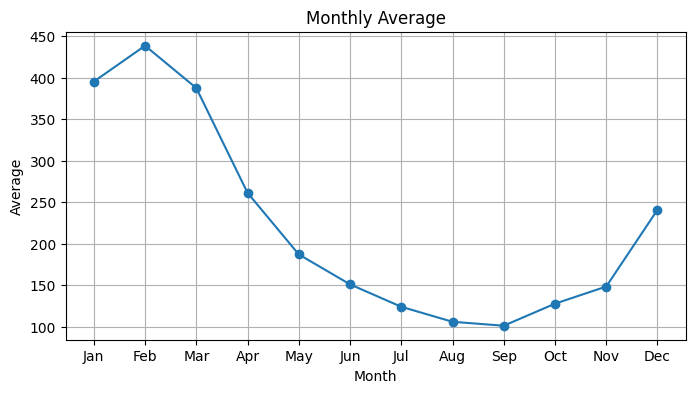

In [8]:
# Python
# === Monthly Averaging ===
months = dates.dt.month
totals = []
averages = []
for ii in range(1, 13):
    idx = np.where(months == ii)[0]
    if len(idx) > 0:
        totals.append(np.sum(flow[idx]))
        averages.append(np.mean(flow[idx]))
    else:
        totals.append(np.nan)
        averages.append(np.nan)

totals = np.array(totals)
averages = np.array(averages)

# Data
# For plotting, we just need the month numbers, 1-12, and some
# labels for them. Python wouldn't understand where 'Jun' will
# go unless we assign 6, then label 6 'Jun'.
month_num = np.arange(1, 13)  # 1 to 12
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(8, 4))
plt.plot(month_num, averages, '-o')
plt.xticks(month_num, month_name) # Use the numbers, but label with the names
plt.title('Monthly Average')
plt.xlabel('Month')
plt.ylabel('Average')
plt.grid(True)
plt.show()

In [9]:
dates

0       1940-09-30
1       1940-10-01
2       1940-10-02
3       1940-10-03
4       1940-10-04
           ...    
29061   2020-04-24
29062   2020-04-25
29063   2020-04-26
29064   2020-04-27
29065   2020-04-28
Name: datetime, Length: 29066, dtype: datetime64[ns]

### Removing NaNs
If you scrolled through the data, you noticed there were some missing values, dates, etc. WE need to remove those from our data set. Maybe when we did our average, there was a date with no value, or a NaN. How does averaging work if I add a NaN? How can we find them efficiently?

In [10]:
# Python 
# Clean NaNs
nan_mask = np.isnan(flow)
dates = dates[~nan_mask]
flow = flow[~nan_mask]

# If all of the NaNs are gone, this should return a zero
sum(np.isnan(flow))

np.int64(0)

### Interpolation
We look at the data, and there may be time gaps, holes, etc. But we want a nice, steady time series, especially for spectral analysis. We need to give a continuous, constant, spaced time series. Currently, we have holes, as well as temporally inconsistent measurements. 

To fix this, we are going to make another data set. This one will have perfectly spaced readings, each an hour apart, and we will use our original data to interpolate to the perfectly spaced uniform data set.

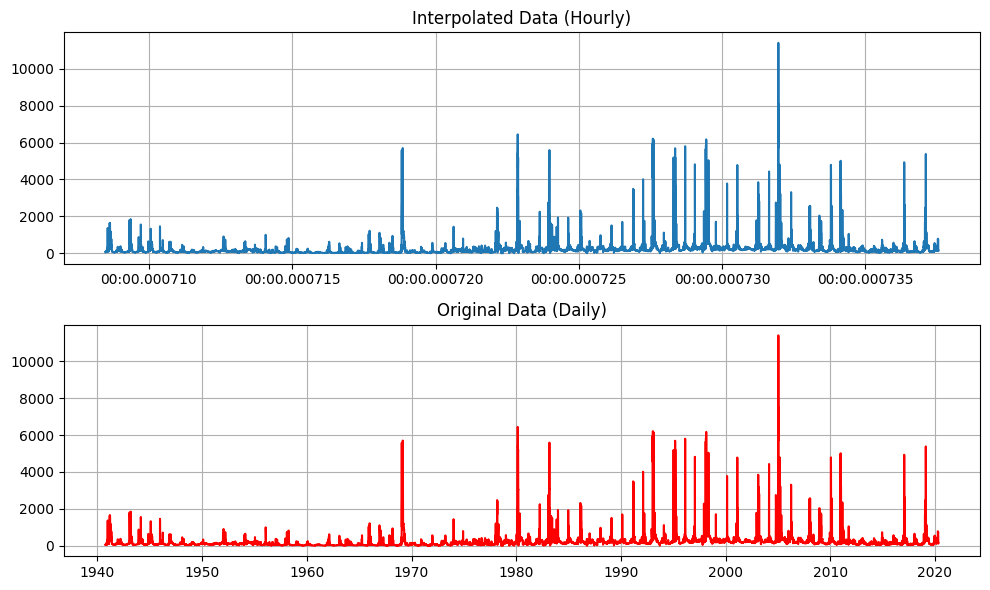

In [12]:
# === Interpolation to hourly ===
# Convert to numeric days since epoch for interpolation
# Is there a nicer way to do this?

datenum = dates.map(pd.Timestamp.toordinal) + (
    dates.dt.hour / 24 + dates.dt.minute / 1440 + dates.dt.second / 86400
)

firstday = datenum.iloc[0]
lastday = datenum.iloc[-1]
xq = np.arange(firstday, lastday, 1/24)

# Creaet the interpolator
pchip_interp = PchipInterpolator(datenum, flow)
# Interpolate flow to the perfect vector xq
yq = pchip_interp(xq)

# Plotting
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
xq_datetime = pd.to_datetime(xq)  # convert back to datetime for plotting
axs[0].plot(xq_datetime, yq)
axs[0].set_title("Interpolated Data (Hourly)")
axs[0].grid()

axs[1].plot(dates, flow, 'r')
axs[1].set_title("Original Data (Daily)")
axs[1].grid()

plt.tight_layout()
plt.show()


### Filtering Data

Sometimes data is noisy. There could be measurement errors, transcription errors, calibration errors, etc. Most data has some natural noise, and to get a clearer picture of any frequencys, you can filter the data.

We can create a filter, a moving window, which will smooth our data out. Imagine a 6-hour moving window, where any reading in that window is averaged together. This does that, more technical and mathy, and moves the window in both directions, to prevent any phase shifting effect of our smoothing.

Here is a simple example, where we create some noisy data around a  known signal (sin), and then pass a filter over it. We can recover most of the underlying signal from the noise!

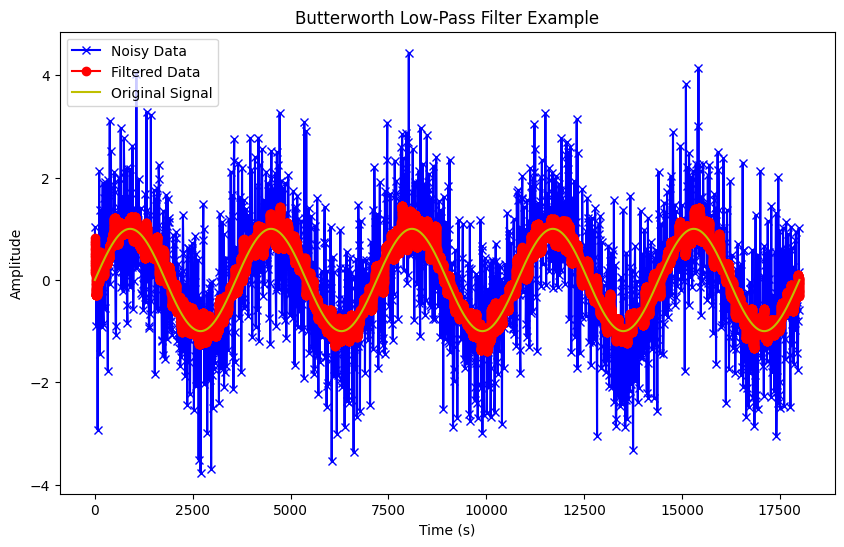

In [13]:
# Python
# Filters
# deciding what filter to use on your data. This is personal, decide what
# is the best option. This uses the Butterworth filter "butter"
t = np.arange(0, 5*3600 + 1, 1)  # from 0 to 5 hours, 1-second intervals

# Nice cyclic data, with noise added
y = np.sin(t * 2 * np.pi / 3600) + np.random.randn(len(t))

# Setup some values for our filters
T = t[1] - t[0]          # 1 second
samplingf = 1 / T        # 1 Hz
cutoff = 1 / 60          # 1/60 Hz, 1 minute cutoff frequency

# Design Butterworth low-pass filter
b, a = butter(2, cutoff / (0.5 * samplingf), btype='low')

# Filter the data both ways to ptry to prevent phase shift, also 
# called zero-phase filtering
fy = filtfilt(b, a, y)

# --- Plot the results ---
plt.figure(figsize=(10, 6))
# Plot every 10th number, so we can see the outliers
plt.plot(t[::10], y[::10], 'b-x', label='Noisy Data')
plt.plot(t, fy, 'r-o', label='Filtered Data')
plt.plot(t, np.sin(t * 2 * np.pi / 3600), 'y', label='Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Butterworth Low-Pass Filter Example')
plt.legend()
plt.show()

Now we can try it with our data!


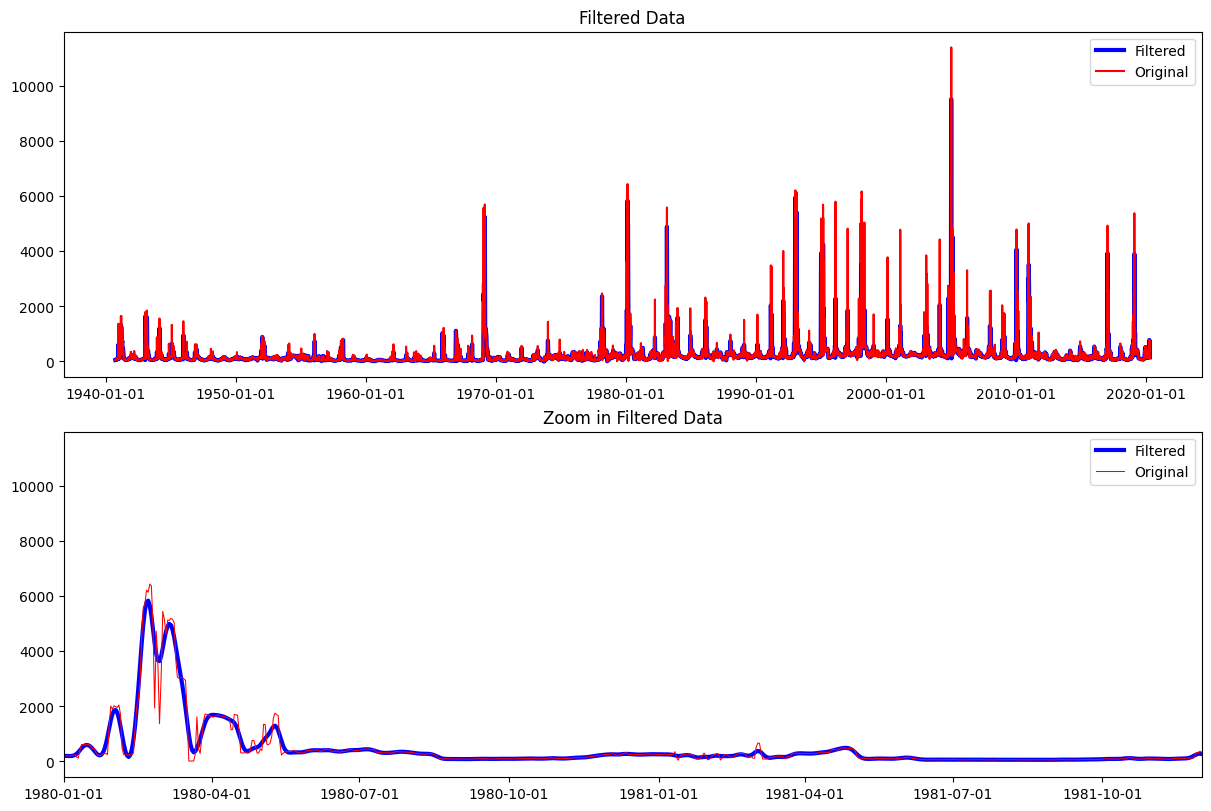

In [17]:
# Python

# --- Filter setup ---
cutoff = 1 / 7  # less than weekly

# Compute sampling interval T based on datetime array
# Convert datetime to matplotlib's float days
date_num = mdates.date2num(dates)  # converts datetime to float days
T = 1 / (date_num[1] - date_num[0])  # sampling frequency in 1/days

# Design Butterworth low-pass filter
# The 0.5 adjusts what the window is.
b, a = butter(2, cutoff / (0.9* T), btype='low')

# Apply filter forwards and backwards (zero-phase)
fx = filtfilt(b, a, flow)

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

# First plot: full series
axs[0].plot(dates, fx, 'b-', linewidth=3, label='Filtered')
axs[0].plot(dates, flow, 'r', label='Original')
axs[0].set_title('Filtered Data')
axs[0].legend()
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Second plot: zoomed in
axs[1].plot(dates, fx, 'b-', linewidth=3, label='Filtered')
axs[1].plot(dates, flow, 'r', linewidth=0.75,label='Original')
axs[1].set_title('Zoom in Filtered Data')
axs[1].set_xlim( [datetime.date(1980,1,1), datetime.date(1981,12,1)] )
axs[1].legend()
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

### Spectral Analysis - Fourier Space

Now, we can take out filtered data, and analyze it in Fourier (frequency) space

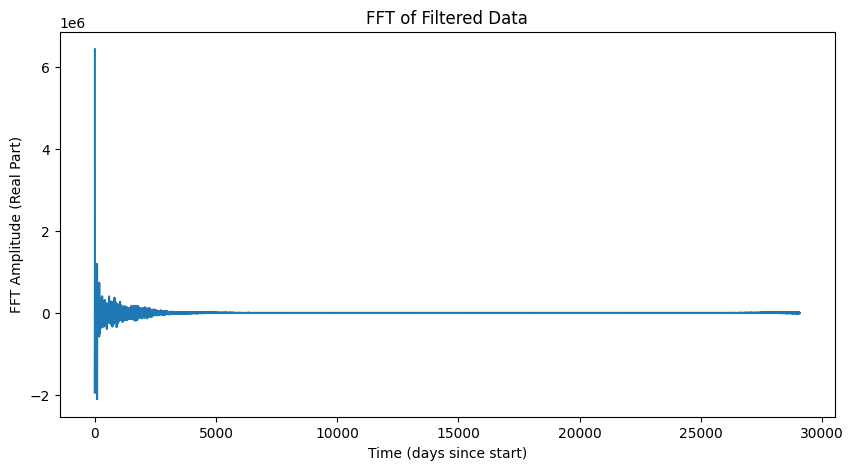

In [18]:
# Python
# --- Convert date to numeric like MATLAB datenum ---
d = mdates.date2num(dates)   # convert datetime array to float days
d = d - d[0] + 1           # shift so first date is day 1

L = len(dates)
# nextpow2 equivalent
n = 2 ** int(np.ceil(np.log2(L)))
dim = 0  # NumPy uses axis=0 for rows, like MATLAB dim=1

# Take FFT along the chosen dimension
orig = np.fft.fft(fx, n=n, axis=dim)

# --- Plot the result ---
plt.figure(figsize=(10, 5))
plt.plot(d, orig[:len(d)].real)  # plot real part (imag part is usually symmetric)
plt.xlabel("Time (days since start)")
plt.ylabel("FFT Amplitude (Real Part)")
plt.title("FFT of Filtered Data")
plt.show()

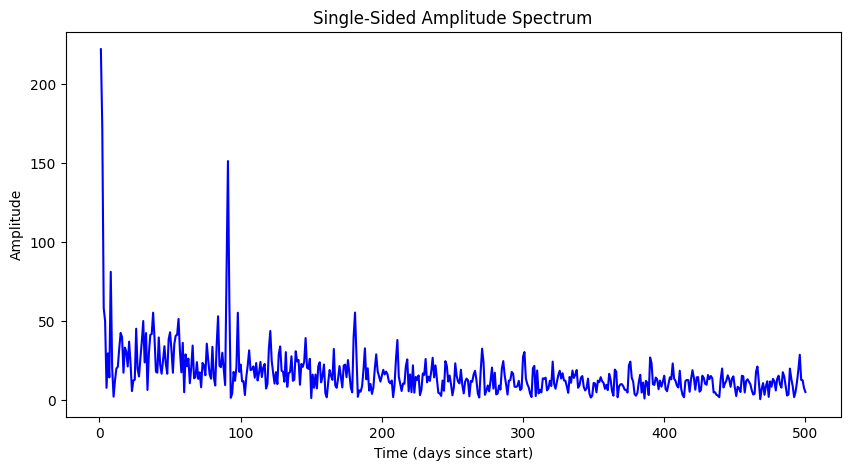

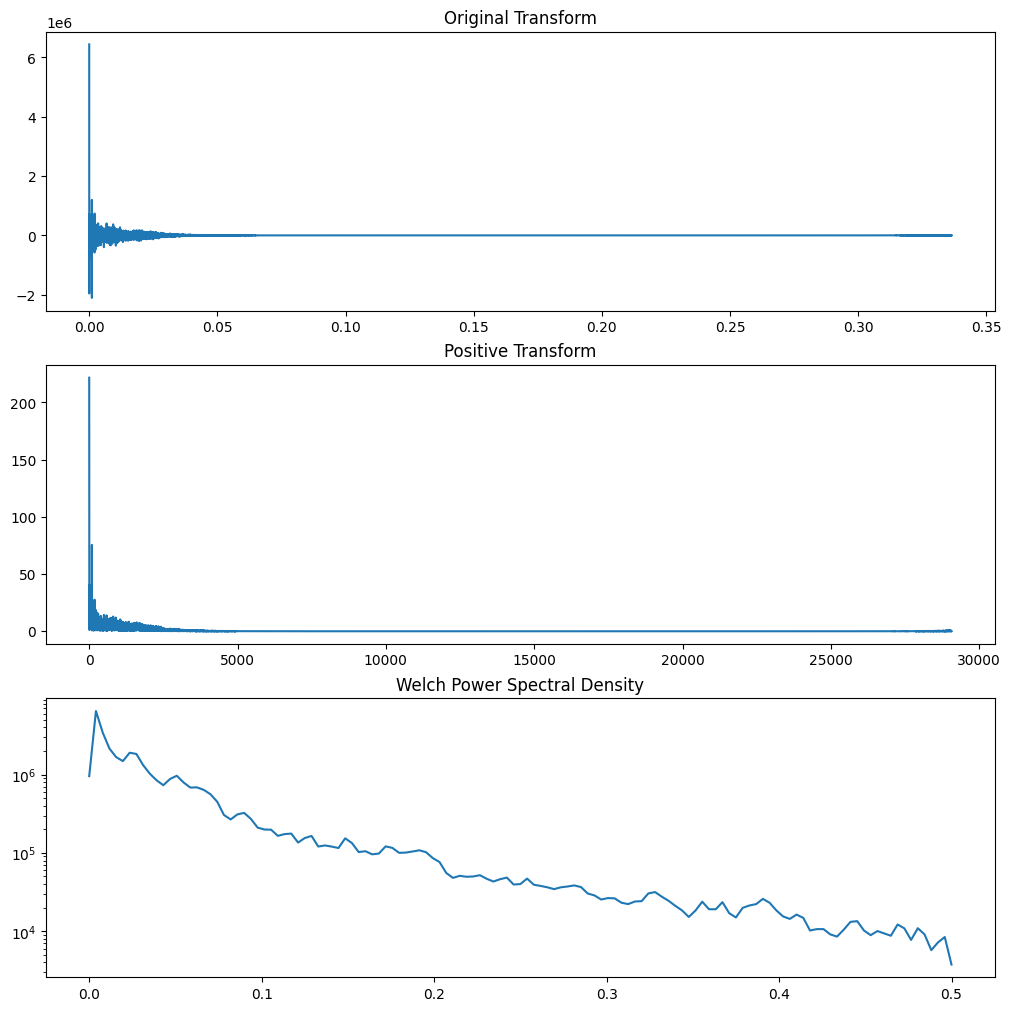

In [19]:
# Python

from scipy.signal import welch

date=dates
# --- Compute FFT quantities ---
L = len(date)
P2 = np.abs(orig / L)

# MATLAB uses n/2 + 1 for positive frequencies
P1 = P2[: int(n // 2) + 1].copy()
P1[1:-1] = 2 * P1[1:-1]

# Convert date to numeric like MATLAB datenum
d = mdates.date2num(date)
d = d - d[0] + 1  # start at 1

# --- Plot first figure: first 500 points of positive FFT spectrum ---
plt.figure(figsize=(10, 5))
plt.plot(d[:500], P1[:500], 'b-')
plt.xlabel("Time (days since start)")
plt.ylabel("Amplitude")
plt.title("Single-Sided Amplitude Spectrum")
plt.show()

# --- Tiled layout (3 subplots) ---
fig, axs = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)

# 1. Original transformed data
axs[0].plot(d / 86400, orig[:len(d)].real)  # divide by 86400 if you want seconds -> days
axs[0].set_title('Original Transform')

# 2. All positive transform
axs[1].plot(d, P2[:len(d)])
axs[1].set_title('Positive Transform')

# 3. Welch Power Spectral Density
f, Pxx = welch(flow, fs=1.0)  # fs=1.0 assumes 1 sample per day (adjust if different)
axs[2].semilogy(f, Pxx)
axs[2].set_title('Welch Power Spectral Density')

plt.show()
